## Cell 1:

In [ ]:
#Cell 1
# okay, so---make a bunch of convolved images
# turn them into simple catalogs
# then calculate the fwhm of the star-like objects in the resultant catalog
# only challenge--I need a seeing FWHM for this thing to run.
#hmm. what do I use for real source extractor runnings? default_dualmode.sex says:
#I manually set it to 0.195 for the F105w filter, and 0.204 for the F606w filter. 
#if I remember correctly, this is mostly used for class_star separation, but that does sort of play a role in
#figuring out what the fwhm of the stars are, which is exactly what we need
#

## Cell 2:

In [8]:
#cell 2
import numpy as np
import array as arr
from astropy import table
#from reproject import reproject_exact ;not reprojecting in here
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
import sewpy
import iterate_convolution as ic
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join
import astropy.table



## Cell 3:

In [1]:
#cell 3
#original files to work with
fileblue='/home/k689j329/HSTdata/j210604m5845/j210604m5845-f606w_drc_sci.fits'
filered='/home/k689j329/HSTdata/j210604m5845/j210604m5845-f105w_drz_sci.fits'
filereprojd='/home/k689j329/HSTdata/j2106_blue2red_exact.fits'
#this reprojd file is the output of the reprojectin.py program

h_red=fits.open(filered)
h_blue=fits.open(filereprojd)
h_original=fits.open(fileblue)
hdr_red=h_red[0].header
hdr_reprj=h_blue[0].header
hdr_ogblue=h_original[0].header
ident1='sept21_'
ident2='sept21b_'

fwhm_blue_pix = 2.5 #well, you need to measure this using imexamine/topcat; this should be true for both blue images, original and reprojected
fwhm_red_pix = 1.85 #well, you need to measure this as ^

NameError: name 'fits' is not defined

## Cell 4:

In [118]:
#cell 4
# iterative convolution
#do some calculations about the range of convolution kernels to try

cd1_red=hdr_red['CD1_1']
cd1_red_arc=abs(cd1_red) * 3600.0
fwhm_red_arc= fwhm_red_pix*cd1_red_arc
table_red=ic.makecat(filered,see=fwhm_red_arc)
pseudomag=(-1.0)*np.log10(table_red['FLUX_APER'])
table_red['MAG']=pseudomag #calcfwhm won't run without a 'Mag' column to select the most 'stellar sequence' of objects
redtable_temp=ic.calcfwhm(table_red,star_limit=0.8,maglow=-2.5,maghigh=-0.25,fwhmlim=3.5)
fwhm_red_recalcd=np.median(redtable_temp['FWHM_IMAGE'])
fwhm_red_recalc_arc=fwhm_red_recalcd*cd1_red_arc
print(fwhm_red_recalc_arc)

#only need this to get a reasonable range for the convolution kernels to try
cd1_blue=hdr_ogblue['CD1_1']
cd1_blue_arc=abs(cd1_blue)*3600.0
fwhm_blue_arc=fwhm_blue_pix*cd1_blue_arc
print('fwhmbluearc',fwhm_blue_arc)

#only need this to convert to the correct pixel scale. 
cd1_reproj=hdr_reprj['CD1_1']
cd1_reproj_arc=abs(cd1_reproj)*3600.0


##Below, we do a first pass at a variety of convolution kernels and then take a look at their results

########an average in-between value would be calculated like this: fwhm2=((fwhmarcred**2.0)-(fwhmarcblue**2.0))**(1/2)
#or set up an array to do several convolutions, which is what is below.

yarray1=np.linspace(fwhm_red_recalc_arc,fwhm_blue_arc,15,endpoint=True)
#that's an appropriate range in arcseconds
yarray=yarray1/cd1_reproj_arc
#now it's in pixels
#print(yarray1)


m=0
files=[]
for item in yarray: #switch this yarray to yarr2 for next iteration
    filename=ic.conv2Dgauss(filereprojd,item,i=m,ident=ident1)
    m+=1
    files.append(filename)
    print(filename)
print('done convolving')


Ouch, SExtractor complains :
b''
/home/k689j329/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


filtered data is size: 24
Median FWHM_IMAGE 1.78 Mean FWHM_IMAGE 1.7470833333333333
0.17799999999999502
fwhmbluearc 0.124999999999992
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_0.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_1.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_2.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_3.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_4.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_5.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_6.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_7.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_8.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_9.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_10.fits
convolving...
/hom

## Cell 5:

In [119]:
#cell 5
#now need to run SE, make a table, and find out how to work with that table
#from making a catalog and visually inspecting it with topcat, we found convolved j2106_f606w's best stellar sequence is fwhm_image <5 mag -2.2 to -1.0
#these parameters are adjustable with default keywords in the calcfwhm function but at the end of the day they will rely somewhat on the fwhm_red_pix and fwhm_blue_pix set in the 2nd cell of this notebook to eventually define what is and is not a star.
#therefore star_limit keyword (which refers to the value of the CLASS_STAR parameter from Source Extractor) can indeed vary significantly depending on what is fed into makecat for the see parameter. I default use fwhm_red_arc (must be in arc per SE's requirements) since that is going to be  unconvolved/we are putting the convolved blue values in TERMS of the red image.
#outdated(newest is sep21)

fwhm_median=[]
i=0
for item in files:
    print(item)
    yval=yarray[i] #in pixels
    yval2=yarray1[i]
    print('convolved by FWHM',yval,'pixels, aka',yval2,'arcsec kernel')
    table1=ic.makecat(item,see=fwhm_red_recalc_arc)
    pseudomags=(-1.0)*np.log10(table1['FLUX_APER'])
    table1['MAG']=pseudomags
    #plt.plot(table1['MAG'],table1['FWHM_IMAGE'],'ro')
    #plt.title('Does the stellar sequence stay appropriate in this pre-determined range?')
    #plt.ylim(0.0,4.5)
    #plt.xlim(-2.2,-1.0)
    #plt.show()
    newlimitedtable=ic.calcfwhm(table1)
    #you can enter plottin=True as an optional argument in calcfwhm
    #that lets you see the stellar sequence that falls in the selection range used for making a new, limited table
    fwhmmed=np.median(newlimitedtable['FWHM_IMAGE'])
    fwhm_median.append(fwhmmed)
    print('-------------')
    i+=1

Ouch, SExtractor complains :
b''


/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_0.fits
convolved by FWHM 1.78 pixels, aka 0.17799999999999502 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 100
Median FWHM_IMAGE 2.19 Mean FWHM_IMAGE 2.3036
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_1.fits
convolved by FWHM 1.7421428571428539 pixels, aka 0.17421428571428052 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 101
Median FWHM_IMAGE 2.16 Mean FWHM_IMAGE 2.248217821782178
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_2.fits
convolved by FWHM 1.7042857142857077 pixels, aka 0.17042857142856602 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 98
Median FWHM_IMAGE 2.11 Mean FWHM_IMAGE 2.2048979591836737
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_3.fits
convolved by FWHM 1.6664285714285618 pixels, aka 0.1666428571428515 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 95
Median FWHM_IMAGE 2.08 Mean FWHM_IMAGE 2.1612631578947368
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_4.fits
convolved by FWHM 1.6285714285714157 pixels, aka 0.162857142857137 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 94
Median FWHM_IMAGE 2.04 Mean FWHM_IMAGE 2.0954255319148936
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_5.fits
convolved by FWHM 1.5907142857142695 pixels, aka 0.1590714285714225 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 92
Median FWHM_IMAGE 2.0 Mean FWHM_IMAGE 2.0584782608695646
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_6.fits
convolved by FWHM 1.5528571428571238 pixels, aka 0.15528571428570803 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 87
Median FWHM_IMAGE 1.95 Mean FWHM_IMAGE 1.9949425287356322
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_7.fits
convolved by FWHM 1.5149999999999777 pixels, aka 0.15149999999999353 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 91
Median FWHM_IMAGE 1.91 Mean FWHM_IMAGE 1.9395604395604396
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_8.fits
convolved by FWHM 1.4771428571428316 pixels, aka 0.14771428571427903 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 92
Median FWHM_IMAGE 1.88 Mean FWHM_IMAGE 1.9314130434782608
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_9.fits
convolved by FWHM 1.4392857142856854 pixels, aka 0.14392857142856452 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 86
Median FWHM_IMAGE 1.84 Mean FWHM_IMAGE 1.9195348837209303
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_10.fits
convolved by FWHM 1.4014285714285395 pixels, aka 0.14014285714285002 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 84
Median FWHM_IMAGE 1.81 Mean FWHM_IMAGE 1.874642857142857
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_11.fits
convolved by FWHM 1.3635714285713934 pixels, aka 0.13635714285713552 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 89
Median FWHM_IMAGE 1.76 Mean FWHM_IMAGE 1.851011235955056
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_12.fits
convolved by FWHM 1.3257142857142472 pixels, aka 0.132571428571421 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 96
Median FWHM_IMAGE 1.725 Mean FWHM_IMAGE 1.7771875
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_13.fits
convolved by FWHM 1.287857142857101 pixels, aka 0.1287857142857065 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 95
Median FWHM_IMAGE 1.67 Mean FWHM_IMAGE 1.727578947368421
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_14.fits
convolved by FWHM 1.249999999999955 pixels, aka 0.124999999999992 arcsec kernel
filtered data is size: 92
Median FWHM_IMAGE 1.605 Mean FWHM_IMAGE 1.6633695652173912
-------------


## Cell 6:

well, originally...


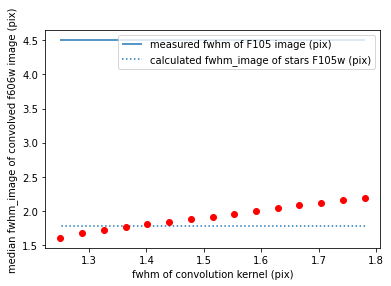

the file identifier that produces the best psf fitting is 11 which uses a FWHM of 1.76
originally, red image's median FWHM was 1.78
so that means, either go onward to calculate a more precise kernel (probably for the best), or use  /home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21_11.fits


In [121]:
##cell 6
#USE THIS PLOT TO MAKE A QUICK DETERMINATION OF WHAT CONVOLUTION KERNEL BEST RE-PRODUCES THE FWHM OF THE RED IMAGE
#the short code below plt.show() does the calculation for you to find k, the identifier for the best-fit kernel fwhm
#also note that due to the yarray set-up, it plots the points from right to left
#so count from right to left if you use the image.

print('well, originally...')
plt.plot(yarray,fwhm_median,'ro')
plt.hlines(fwhm_red_pix,xmin=yarray[0],xmax=yarray[len(yarray)-1],label='measured fwhm of F105 image (pix)')
plt.hlines(fwhm_red_recalcd,xmin=yarray[0],xmax=yarray[len(yarray)-1],label='calculated fwhm_image of stars F105w (pix)',linestyle=':')
plt.xlabel('fwhm of convolution kernel (pix)')
plt.ylabel('median fwhm_image of convolved f606w image (pix)')
plt.legend()
plt.show()

#this figures out which of the results is the best fit to the required PSF
s=abs(fwhm_median-fwhm_red_recalcd)
g=[]
#b='%.3f'%s[:]
#print(b)
for n in s:
    f='%.3f'%n
    r= float(f) == np.around(s.min(),3)
    g.append(r)

k= int(np.where(g)[0])
print('the file identifier that produces the best psf fitting is',k,'which uses a FWHM of',fwhm_median[k])
print('originally, red image\'s median FWHM was',fwhm_red_recalcd)
print('so that means, either go onward to calculate a more precise kernel (probably for the best), or use ',files[k])

## Cell 7:

In [122]:
#cell 7
#For a more accurate convolution, take the best fit point at k and convolve more closely around it.
#
#use yarr2 in replace of yarray1
ymax=yarray1[k]+0.01
ymin=yarray1[k]-0.01
ya2=np.linspace(ymax,ymin,20,endpoint=True)
yarr2=ya2/cd1_reproj_arc


i=0
files2=[]
for item2 in yarr2: #now use yarr2 for higher precision
    filename2=ic.conv2Dgauss(filereprojd,item2,i,ident=ident2)
    i+=1
    files2.append(filename2)
    print(filename2)
print('done convolving')

convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_0.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_1.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_2.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_3.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_4.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_5.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_6.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_7.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_8.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_9.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_10.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_11.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv

## Cell 8:

In [123]:
#cell 8
#the same as Cell 4 above-- calculate the resultant fwhm for the convolved images
fwhm_median2=[]
j=0
for item in files2:
    print(item)
    yval=yarr2[j] #in pixels
    yval2=ya2[j] #in arcsec
    print('convolved by FWHM',yval,'pixels, aka',yval2,'arcsec kernel')
    table2=ic.makecat(item,see=fwhm_red_pix)
    pseudomags2=(-1.0)*np.log10(table2['FLUX_APER'])
    table2['MAG']=pseudomags2
    #plt.plot(table1['MAG'],table1['FWHM_IMAGE'],'ro')
    #plt.title('Does the stellar sequence stay appropriate in this pre-determined range?')
    #plt.ylim(0.0,4.5)
    #plt.xlim(-2.2,-1.0)
    #plt.show() 
    newlimitedtable2=ic.calcfwhm(table2)
    #you can enter plottin=True as an optional argument in calcfwhm
    #that lets you see the stellar sequence that falls in the selection range used for making a new, limited table
    fwhmmed2=np.median(newlimitedtable2['FWHM_IMAGE'])
    fwhm_median2.append(fwhmmed2)
    print('-------------')
    j+=1
    

Ouch, SExtractor complains :
b''


/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_0.fits
convolved by FWHM 1.463571428571396 pixels, aka 0.14635714285713552 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 160
Median FWHM_IMAGE 1.87 Mean FWHM_IMAGE 2.0568125
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_1.fits
convolved by FWHM 1.4530451127819224 pixels, aka 0.14530451127818816 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 160
Median FWHM_IMAGE 1.86 Mean FWHM_IMAGE 2.0440625
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_2.fits
convolved by FWHM 1.4425187969924482 pixels, aka 0.14425187969924078 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 160
Median FWHM_IMAGE 1.8450000000000002 Mean FWHM_IMAGE 2.02925
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_3.fits
convolved by FWHM 1.4319924812029743 pixels, aka 0.14319924812029342 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 160
Median FWHM_IMAGE 1.84 Mean FWHM_IMAGE 2.0158125
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_4.fits
convolved by FWHM 1.4214661654135003 pixels, aka 0.14214661654134605 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 161
Median FWHM_IMAGE 1.83 Mean FWHM_IMAGE 2.0101242236024843
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_5.fits
convolved by FWHM 1.4109398496240262 pixels, aka 0.14109398496239867 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 162
Median FWHM_IMAGE 1.81 Mean FWHM_IMAGE 1.9959876543209878
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_6.fits
convolved by FWHM 1.4004135338345522 pixels, aka 0.1400413533834513 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 164
Median FWHM_IMAGE 1.8 Mean FWHM_IMAGE 1.996646341463415
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_7.fits
convolved by FWHM 1.3898872180450783 pixels, aka 0.13898872180450395 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 166
Median FWHM_IMAGE 1.79 Mean FWHM_IMAGE 1.9849397590361446
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_8.fits
convolved by FWHM 1.3793609022556044 pixels, aka 0.13793609022555658 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 166
Median FWHM_IMAGE 1.77 Mean FWHM_IMAGE 1.971987951807229
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_9.fits
convolved by FWHM 1.3688345864661302 pixels, aka 0.1368834586466092 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 166
Median FWHM_IMAGE 1.76 Mean FWHM_IMAGE 1.9663855421686751
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_10.fits
convolved by FWHM 1.3583082706766563 pixels, aka 0.13583082706766184 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 169
Median FWHM_IMAGE 1.75 Mean FWHM_IMAGE 1.9592307692307693
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_11.fits
convolved by FWHM 1.3477819548871826 pixels, aka 0.13477819548871448 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 169
Median FWHM_IMAGE 1.73 Mean FWHM_IMAGE 1.9466272189349114
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_12.fits
convolved by FWHM 1.3372556390977082 pixels, aka 0.1337255639097671 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 169
Median FWHM_IMAGE 1.72 Mean FWHM_IMAGE 1.9345562130177514
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_13.fits
convolved by FWHM 1.3267293233082345 pixels, aka 0.13267293233081973 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 168
Median FWHM_IMAGE 1.7 Mean FWHM_IMAGE 1.9153571428571428
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_14.fits
convolved by FWHM 1.3162030075187605 pixels, aka 0.13162030075187237 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 168
Median FWHM_IMAGE 1.69 Mean FWHM_IMAGE 1.9000000000000004
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_15.fits
convolved by FWHM 1.3056766917292864 pixels, aka 0.13056766917292498 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 167
Median FWHM_IMAGE 1.68 Mean FWHM_IMAGE 1.8766467065868262
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_16.fits
convolved by FWHM 1.2951503759398124 pixels, aka 0.12951503759397762 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 170
Median FWHM_IMAGE 1.67 Mean FWHM_IMAGE 1.8864705882352937
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_17.fits
convolved by FWHM 1.2846240601503385 pixels, aka 0.12846240601503026 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 173
Median FWHM_IMAGE 1.65 Mean FWHM_IMAGE 1.8872832369942196
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_18.fits
convolved by FWHM 1.2740977443608643 pixels, aka 0.12740977443608287 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 174
Median FWHM_IMAGE 1.64 Mean FWHM_IMAGE 1.868448275862069
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_19.fits
convolved by FWHM 1.2635714285713904 pixels, aka 0.1263571428571355 arcsec kernel
filtered data is size: 174
Median FWHM_IMAGE 1.625 Mean FWHM_IMAGE 1.8560344827586204
-------------


## Cell 9:

well, originally...


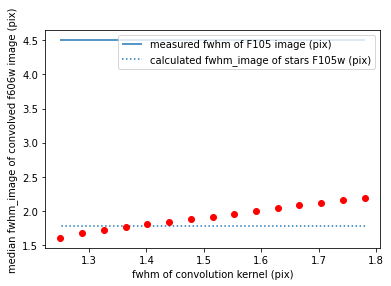

now, with higher accuracy:


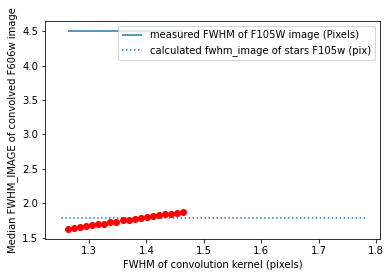

[7 8]
the file identifier that produces the best psf fitting is 7 which uses a FWHM of 1.79
originally, red image's median FWHM was 1.78
so use  /home/k689j329/HSTdata/j2106_blue2red_exact_conv_sept21b_7.fits


In [131]:
#cell 9
###now, compare the two plots

#also note that due to the yarray set-up, it plots the points from right to left
#so count from right to left if you use the image.
print('well, originally...')
plt.plot(yarray,fwhm_median,'ro')
plt.hlines(fwhm_red_pix,xmin=yarray[0],xmax=yarray[len(yarray)-1],label='measured fwhm of F105 image (pix)')
plt.hlines(fwhm_red_recalcd,xmin=yarray[0],xmax=yarray[len(yarray)-1],label='calculated fwhm_image of stars F105w (pix)',linestyle=':')
plt.xlabel('fwhm of convolution kernel (pix)')
plt.ylabel('median fwhm_image of convolved f606w image (pix)')
plt.legend()
plt.show()

#also note that due to the yarr2 set-up, it plots the points from right to left
#so count from right to left if you use the image.
print('now, with higher accuracy:')
plt.plot(yarr2,fwhm_median2,'ro')
plt.hlines(fwhm_red_pix,xmin=yarr2[0],xmax=yarr2[len(yarr2)-1],label='measured FWHM of F105W image (Pixels)')
plt.hlines(fwhm_red_recalcd,xmin=yarray[0],xmax=yarray[len(yarray)-1],label='calculated fwhm_image of stars F105w (pix)',linestyle=':')
plt.xlabel('FWHM of convolution kernel (pixels)')
plt.ylabel('Median FWHM_IMAGE of convolved F606w image')
plt.legend()
plt.show()


o=abs(fwhm_median2-fwhm_red_recalcd)
p=[]
#b='%.3f'%s[:]
#print(b)
for y in o:
    f='%.3f'%y
    r= float(f) == np.around(o.min(),3)
    p.append(r)

t= int(np.where(p)[0])
print('the file identifier that produces the best psf fitting is',t,'which uses a FWHM of',fwhm_median2[t])
print('originally, red image\'s median FWHM was',fwhm_red_recalcd)
print('so use ',files2[t])

# **below this is a mostly obsolete example. 'ware all who enter here**

Ouch, SExtractor complains :
b''
/home/k689j329/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
Ouch, SExtractor complains :
b''


table105 seeing and pixel scale 0.19499999999999454 0.0999999999999972
filtered data is size: 23
Median FWHM_IMAGE 1.83 Mean FWHM_IMAGE 1.856086956521739
table blue seeing and pixel scale should be familiar 0.2039999999999943 0.0999999999999972
filtered data is size: 78
Median FWHM_IMAGE 1.84 Mean FWHM_IMAGE 1.8984615384615382


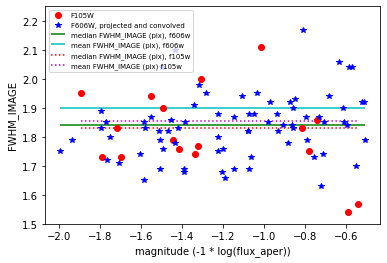

/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_5.fits


In [20]:
####### an example used to see how well a file fits a particular set up. 

goodfilered=filered
hrp=fits.open(goodfilered)
goodfileblue=files[5]

#since feb217 is the 'good one', the best convolution, let's look at the stellar sequence of that compared to F105w
hdr_105=hrp[0].header
fwhmpix105=1.95
cd1_105=hdr_105['CD1_1']
cd105_arc=abs(cd1_105)*3600.0
fwhmarc105=fwhmpix105*cd105_arc
table105=ic.makecat(goodfilered,see=fwhmarc105,ps=cd105_arc)
print('table105 seeing and pixel scale',fwhmarc105,cd105_arc)
magsr=(-1.0)*np.log10(table105['FLUX_APER'])
table105['MAG']=magsr
limitable105=ic.calcfwhm(table105)

blueimage=goodfileblue
hdb=fits.open(blueimage)
hdr_blue2=hdb[0].header
#fpixb=1.95
fpixb=2.04
#gack. where does fpixb come from again? may need to re-measure it
cd_blue2=hdr_blue2['CD1_1']
cd_arcblue2= abs(cd_blue2)*3600.0
farcb=fpixb*cd_arcblue2
tab_blu=ic.makecat(blueimage,see=farcb,ps=cd_arcblue2)
print('table blue seeing and pixel scale should be familiar',farcb,cd_arcblue2)
mblu=(-1.0)*np.log10(tab_blu['FLUX_APER'])
tab_blu['MAG']=mblu
limblu=ic.calcfwhm(tab_blu)

plt.plot(limitable105['MAG'],limitable105['FWHM_IMAGE'],'ro',label='F105W')
plt.plot(limblu['MAG'],limblu['FWHM_IMAGE'],'b*',label='F606W, projected and convolved')
plt.hlines(np.median(limblu['FWHM_IMAGE']),xmin=np.min(limblu['MAG']),xmax=np.max(limblu['MAG']),color='g',label='median FWHM_IMAGE (pix), f606w')
plt.hlines(np.mean(limblu['FWHM_IMAGE']),xmin=np.min(limblu['MAG']),xmax=np.max(limblu['MAG']),color='c',label='mean FWHM_IMAGE (pix), f606w')
plt.hlines(np.median(limitable105['FWHM_IMAGE']),xmin=np.min(limitable105['MAG']),xmax=np.max(limitable105['MAG']),linestyle=':',color='r',label='median FWHM_IMAGE (pix), f105w')
plt.hlines(np.mean(limitable105['FWHM_IMAGE']),xmin=np.min(limitable105['MAG']),xmax=np.max(limitable105['MAG']),color='m',linestyle=':',label='mean FWHM_IMAGE (pix) f105w')
#plt.hlines(1.95,xmin=yarray[0],xmax=yarray[len(yarray)-1],label='measured FWHM of F105W image (Pixels)')
plt.xlabel('magnitude (-1 * log(flux_aper))')
plt.ylim(1.5,2.25)
plt.ylabel('FWHM_IMAGE')
plt.legend(fontsize='x-small',loc="upper left")
plt.show()

print(files[5])


#plt.scatter(limtablereproj['MAG'],limtablereproj['FWHM_IMAGE'])
#plt.scatter(limitable105['MAG'],limitable105['FWHM_IMAGE'])
#plt.show()